In [9]:
from astropy.table import Table
import numpy as np
from astropy.wcs import WCS
from astropy import coordinates
from astropy import wcs
from astropy.nddata.utils import Cutout2D
from dendrocat.aperture import Ellipse
from radio_beam import Beam
from astropy import units as u
from regions import Regions
from itertools import chain
from astropy.stats import mad_std
from astropy.io import fits
W51b3 = '/orange/adamginsburg/w51/TaehwaYoo/2017.1.00293.S_W51_B3_LB/may2021_successful_imaging/'

w51conv = '/orange/adamginsburg/w51/TaehwaYoo/convolved_new/'

w51n_b6_conv = w51conv + 'w51n_cont_bigbriggs.image.convB3_briggs.fits'
w51n_b3_tt0 = W51b3+'w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt0.pbcor.fits'

w51e_b6_conv = w51conv + 'w51e2_cont_bigbriggs.image.convB3_briggs.fits'
w51e_b3_tt0 = W51b3+'w51e2.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt0.pbcor.fits'

w51e_b3_almaimf_noiseregion = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51e_b3_rms.reg'
w51e_b6_almaimf_noiseregion = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51e_b3_rms.reg'

w51n_b3_almaimf_noiseregion = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51n_b3_rms.reg'
w51n_b6_almaimf_noiseregion = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51n_b3_rms.reg'


w51e_b3_noiseregion = '/orange/adamginsburg/w51/TaehwaYoo/w51e_b3_std_sky.reg'
w51e_b6_noiseregion = '/orange/adamginsburg/w51/TaehwaYoo/w51e_std_sky.reg'
w51n_b3_noiseregion = '/orange/adamginsburg/w51/TaehwaYoo/w51n_b3_std_sky.reg'
w51n_b6_noiseregion = '/orange/adamginsburg/w51/TaehwaYoo/w51n_std_sky.reg'

def measure_rms(data, noiseregiondir):
    fitsdata = fits.open(data)
    noiseregion= Regions.read(noiseregiondir,format='ds9')
    image = fitsdata[0].data
    if len(image.shape)!=2:
        image = fitsdata[0].data[0][0]
    
    wcs = WCS(fitsdata[0].header,naxis=2)

    container = []
    for reg in noiseregion:
        pix_reg = reg.to_pixel(wcs)
        noisemask = pix_reg.to_mask()
        noiseim = noisemask.cutout(image)
        container.append(noiseim.flatten())
    noiseim = list(chain.from_iterable(container))
    std = mad_std(noiseim,ignore_nan=True)
    return std

# matched kind-->0
# only B3 kind-->1--> upper limit 
# only B6 kind-->2--> lowerlimit for si
def combine_table_b3b6(b3data, b6data, table_b3, table_b6, b3_noiseregion, b6_noiseregion, savename):
    alpha_b3 = table_b3['alpha']
    x_sky_b3 = table_b3['x_sky_b3']
    y_sky_b3 = table_b3['y_sky_b3']

    x_pix_b3 = table_b3['x_pix_b3']
    y_pix_b3 = table_b3['y_pix_b3']

    ismatched_b3 = table_b3['ismatched_b3']
    
    alpha_b6 = table_b6['alpha']
    x_sky_b6 = table_b6['x_sky_b6']
    y_sky_b6 = table_b6['y_sky_b6']

    x_pix_b6 = table_b6['x_pix_b6']
    y_pix_b6 = table_b6['y_pix_b6']
    
    ismatched_b6 = table_b6['ismatched_b6']

    
    fitsdata_b3 = fits.open(b3data)
    imageb3 = fitsdata_b3[0].data
    if len(imageb3.shape)!=2:
        imageb3 = imageb3[0][0]
    
    fitsdata_b6 = fits.open(b6data)
    imageb6 = fitsdata_b6[0].data
    if len(imageb6.shape)!=2:
        imageb6 = imageb6[0][0]
        
  
    hdrNB6 = fits.getheader(b6data)  
    hdrNB3 = fits.getheader(b3data)  
    wcsNB3 = WCS(hdrNB3,naxis=2)
    wcsNB6 = WCS(hdrNB6,naxis=2)
    
    my_beamNB6 = Beam.from_fits_header(hdrNB6)
    my_beamNB3 = Beam.from_fits_header(hdrNB3)
    scaleNB3 = wcsNB3.proj_plane_pixel_scales()[0]
    scaleNB6 = wcsNB6.proj_plane_pixel_scales()[0]
    
    
    b6flux = get_flux(imageb6, np.vstack((x_pix_b6,y_pix_b6)).T, my_beamNB6, wcsNB6, scaleNB6)
    b3flux = get_flux(imageb3, np.vstack((x_pix_b3,y_pix_b3)).T, my_beamNB3, wcsNB3, scaleNB3)
    b3rms = measure_rms(b3data, b3_noiseregion) 
    b6rms = measure_rms(b6data, b6_noiseregion) 

    print(b6flux)
        
        
    ismatched_b6 = table_b6['ismatched_b6']
    unmatched_b3 = np.where(ismatched_b3==False)[0]
    matched_b6 = np.where(ismatched_b6==True)[0]
    unmatched_b6 = np.where(ismatched_b6==False)[0]
    
    alpha = np.append(alpha_b3, alpha_b6[unmatched_b6])
    x_sky = np.append(x_sky_b3, x_sky_b6[unmatched_b6])
    y_sky = np.append(y_sky_b3, y_sky_b6[unmatched_b6])
    x_pix = np.append(x_pix_b3, x_pix_b6[unmatched_b6])
    y_pix = np.append(y_pix_b3, y_pix_b6[unmatched_b6])
    b3flux = np.append(b3flux, b3rms*np.ones(len(unmatched_b6)))
    b6flux_sum = np.append(b6flux[matched_b6], b6rms*np.ones(len(unmatched_b3)))
    b6flux = np.append(b6flux_sum, b6flux[unmatched_b6])
    kind = np.zeros(len(alpha))
    print(len(alpha_b3),len(alpha),np.arange(len(alpha_b3),len(alpha)))
    kind[np.arange(len(alpha_b3),len(alpha))]=2
    kind[unmatched_b3]=1
    t = Table([x_sky,y_sky,x_pix,y_pix,alpha,b3flux, b6flux, kind],
              names=['x_sky','y_sky','x_pix','y_pix','alpha','b3flux','b6flux','kind'])
    t.write(savename,overwrite=True,format='fits')
    
def get_flux(data,peakxy, beam1, wcsNB, pixel_scale, issky=False,savedir=None):
    fluxarr = []

    if issky:
        cen_world = peakxy
    else:
        cen_world = wcsNB.wcs_pix2world(peakxy,0)
    num_source = len(cen_world)
    print('cen_world',cen_world,len(cen_world))
    
    for i in range(num_source):
        
        #x_cen = peakxy[i][0]
        #y_cen = peakxy[i][1]
        #cen = (x_cen, y_cen)
        major = beam1.major
        minor = beam1.minor
        pa = beam1.pa
    

        positions = coordinates.SkyCoord(cen_world[i,0],cen_world[i,1], frame=wcs.utils.wcs_to_celestial_frame(wcsNB).name,unit=(u.deg,u.deg))
        cutout = Cutout2D(data, positions, 4.0*major, wcs=wcsNB, mode='partial')
        frame = wcs.utils.wcs_to_celestial_frame(cutout.wcs).name
        aperture = Ellipse(positions, major, minor, -1*pa, unit=u.deg, frame=frame) # pa in degree with anti-clockwise direction
        this_mask = aperture.place(cutout.data, wcs=cutout.wcs)
        pixel_scale_sr = (pixel_scale.value * np.pi/180)**2 # pixel scale in deg^2 -> sr
        fluxarr.append(np.sum(cutout.data[this_mask]/beam1.sr.value*pixel_scale_sr)) # Jy/beam / (sr/beam) * (sr/pixel) = Jy/ pixel
        if savedir is not None:
            fig = plt.figure(figsize=(10,10))
            ax1=fig.add_axes([0.2,0.2,0.8,0.8],projection=wcsNB)
            ax1.imshow(cutout.data, origin='lower')
            ax1.imshow(this_mask, origin='lower',alpha=0.1,cmap='gray')
            plt.savefig(savedir+'aper_%04d.png'%i)
            plt.close()
    return np.array(fluxarr) 
    
table_b3 = Table.read('w51e_b3_catalog.fits',format='fits')
table_b6 = Table.read('w51e_b6_catalog.fits',format='fits')

combine_table_b3b6(w51e_b3_tt0, w51e_b6_conv,table_b3,table_b6,w51e_b3_noiseregion, w51e_b6_noiseregion,
                   'w51e_combined_catalog.fits')

    
table_b3 = Table.read('w51n_b3_catalog.fits',format='fits')
table_b6 = Table.read('w51n_b6_catalog.fits',format='fits')
    
    
    
combine_table_b3b6(w51n_b3_tt0, w51n_b6_conv,table_b3,table_b6,
                   w51n_b3_noiseregion, w51n_b6_noiseregion,'w51n_combined_catalog.fits')







cen_world [[290.93232567  14.50541111]
 [290.93225106  14.50594167]
 [290.93236153  14.50620555]
 [290.93248204  14.50622083]
 [290.93243039  14.50623472]
 [290.93257672  14.50649722]
 [290.93262837  14.50699167]
 [290.93340737  14.50702361]
 [290.93371725  14.50703333]
 [290.9327331   14.50711944]
 [290.93331699  14.50714444]
 [290.9332553   14.50725972]
 [290.93278044  14.50727361]
 [290.93268001  14.50734306]
 [290.93348484  14.5073625 ]
 [290.93274888  14.50737778]
 [290.93280913  14.50742222]
 [290.93346906  14.50754583]
 [290.93274457  14.50756528]
 [290.93288947  14.50758194]
 [290.93291243  14.50763889]
 [290.93287512  14.50773611]
 [290.93283926  14.50780139]
 [290.93295403  14.50781667]
 [290.93293251  14.50784861]
 [290.93283782  14.50789583]
 [290.93203586  14.50896944]
 [290.93330265  14.50920556]
 [290.93388655  14.50927222]
 [290.93365127  14.50930833]
 [290.93315918  14.50950694]
 [290.93297985  14.50961111]
 [290.93294399  14.5095625 ]
 [290.93319075  14.50958333]
 [29

97 56 31 10
22 21 1 0


Text(0, 0.5, 'The number of YSOs')

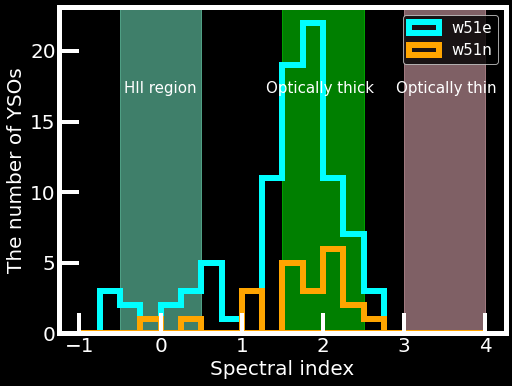

In [36]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams['axes.labelsize']=20
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['axes.titlesize']=20
plt.style.use('dark_background')
mpl.rcParams['xtick.major.size'] = 20
mpl.rcParams['xtick.major.width'] = 4
mpl.rcParams['xtick.minor.size'] = 10
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 20
mpl.rcParams['ytick.major.width'] = 4
mpl.rcParams['ytick.minor.size'] = 10
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['axes.linewidth']=5
fig = plt.figure(figsize=(8,6))
w51ecata = Table.read('w51e_combined_catalog.fits')
bins = np.linspace(-1,4,num=21)
plt.axvspan(-0.5,0.5,alpha=0.5, color='aquamarine')
plt.text(-0.45,17, 'HII region',fontsize=15)
plt.axvspan(1.5,2.5,alpha=0.5, color='lime')
plt.text(1.3,17, 'Optically thick',fontsize=15)
plt.axvspan(3,4,alpha=0.5, color='pink')
plt.text(2.9,17, 'Optically thin',fontsize=15)

plt.hist(w51ecata['alpha'], histtype='stepfilled', bins=bins,facecolor='None',edgecolor='cyan',lw=6,label='w51e')
print(len(w51ecata['alpha']),len(np.where(w51ecata['kind']==0)[0]), len(np.where(w51ecata['kind']==1)[0]),len(np.where(w51ecata['kind']==2)[0]))
w51ncata = Table.read('w51n_combined_catalog.fits')
plt.hist(w51ncata['alpha'], histtype='stepfilled', bins=bins,facecolor='None',edgecolor='orange',lw=6,label='w51n')
print(len(w51ncata['alpha']),len(np.where(w51ncata['kind']==0)[0]), len(np.where(w51ncata['kind']==1)[0]),len(np.where(w51ncata['kind']==2)[0]))

plt.legend(fontsize=15)
plt.tick_params(axis="y",direction='in')
plt.tick_params(axis="x",direction='in')

plt.xlabel('Spectral index')
plt.ylabel('The number of YSOs')